In [ ]:
from sklearn.datasets import fetch_openml
mnist=fetch_openml('mnist_784',version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

In [ ]:
X,y=mnist['data'],mnist["target"]
X.shape,y.shape

((70000, 784), (70000,))

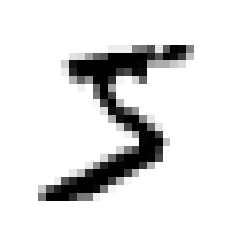

In [ ]:
##Let's check them instances
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit=X[0]
some_digit_image=some_digit.reshape(28,28)

plt.imshow(some_digit_image,cmap=mpl.cm.binary,interpolation="nearest")
plt.axis("off")
plt.show()

In [ ]:
y[0]

'5'

In [ ]:
##Converting tragets to nums
import numpy as np

y=y.astype(np.uint8)

X_train,X_test,y_train,y_test=X[:60000],X[60000:],y[:60000],y[60000:]

In [ ]:
##Training a binary classifer..only 5 detector

y_train_5=(y_train==5)
y_test_5=y_test==5

In [ ]:
y_test_5[0]

True

In [ ]:
##NOTE....SGD is capable of handling large datasets as it handles training instances independently,one at a time..which makes it suitable for online learning

from sklearn.linear_model import SGDClassifier

sgd_clf=SGDClassifier(random_state=42)
sgd_clf.fit(X_train,y_train_5)

sgd_clf.predict([some_digit])

array([ True])

In [ ]:
##Accuracy using Cross validation

from sklearn.model_selection import StratifiedKFold

from sklearn.base import clone

sk_count=0

skfolds=StratifiedKFold(n_splits=5,random_state=42)

for train_index,test_index in skfolds.split(X_train,y_train_5):
  clone_clf=clone(sgd_clf)
  print("TRAIN_INDEX:::",train_index)
  X_train_folds=X_train[train_index]
  y_train_folds=y_train_5[train_index]
  X_test_fold=X_train[test_index]
  y_test_fold=y_train_5[test_index]

  clone_clf.fit(X_train_folds,y_train_folds)

  y_pred=clone_clf.predict(X_test_fold)
  n_correct=sum(y_pred==y_test_fold)
  print(n_correct/len(y_pred))
  print("proportions:",len(X_train_folds)/len(X_train))

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


TRAIN_INDEX::: [11959 11960 11961 ... 59997 59998 59999]
0.9546666666666667
proportions: 0.8
TRAIN_INDEX::: [    0     1     2 ... 59997 59998 59999]
0.96975
proportions: 0.8
TRAIN_INDEX::: [    0     1     2 ... 59997 59998 59999]
0.9635
proportions: 0.8
TRAIN_INDEX::: [    0     1     2 ... 59997 59998 59999]
0.9653333333333334
proportions: 0.8
TRAIN_INDEX::: [    0     1     2 ... 48134 48143 48161]
0.9484166666666667
proportions: 0.8


In [ ]:
##Let's use cross_val_score to evaluate the sgdclassidier using the k-fold cross-validation
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf,X_train,y_train_5,cv=5,scoring="accuracy")

array([0.95466667, 0.96975   , 0.9635    , 0.96533333, 0.94841667])

In [ ]:
##This does not paint the full picture

##let's create a dumb classifier that predicts everything as not 5

from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
  def fit(self,X,y=None):
    pass
  def predict(self,X):
    return np.zeros((len(X),1),dtype=bool)  

In [ ]:
never_5_clf=Never5Classifier()
cross_val_score(never_5_clf,X_train,y_train_5,cv=5,scoring="accuracy")

array([0.91266667, 0.90866667, 0.9095    , 0.90883333, 0.90858333])

In [ ]:
##Athough it looks good on paper..but this sucks for obvious reasons...one beiong that 10 percent of the data is "5"..and misclassifying them brings the model accuracy only 
##to 90.5 percent on an average

In [ ]:
##Here come a better metric for such skewd datasets
##CONFUSION MATRIX

In [ ]:
from sklearn.model_selection import cross_val_predict##same as cross_val_score but returns predictions made on each test fold instead of scores

y_train_pred=cross_val_predict(sgd_clf,X_train,y_train_5,cv=5)

In [ ]:
y_train_pred

array([ True, False, False, ...,  True, False, False])

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5,y_train_pred)

array([[53115,  1464],
       [  916,  4505]])

In [ ]:
##Each row represents an actual class..each column represents a predicted class

##Let's now head to precision...Precison=TP/TP+FP
##recall=TP/TP+FN

from sklearn.metrics import precision_score,recall_score
precision_score(y_train_5,y_train_pred)

0.7547327860613168

In [ ]:
recall_score(y_train_5,y_train_pred)

0.8310274857037447

In [ ]:
##f1score..combos both precison and recall....F=2PR/P+R
from sklearn.metrics import f1_score
f1_score(y_train_5,y_train_pred)

0.791044776119403

In [ ]:
##See not that great..okay..but not that great..let's do some precison VS recall ploting

y_scores=cross_val_predict(sgd_clf,X_train,y_train_5,cv=3,method="decision_function")##it now returns the decison scores instead of predictions because of the method property

from sklearn.metrics import precision_recall_curve

precisions,recalls,thresholds=precision_recall_curve(y_train_5,y_scores)



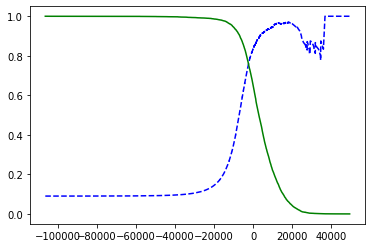

In [ ]:
def plot_precision_vs_recall(precisions,recalls,thresholds):
  plt.plot(thresholds,precisions[:-1],"b--",label="Precision")
  plt.plot(thresholds,recalls[:-1],"g-",label="Recall")

plot_precision_vs_recall(precisions,recalls,thresholds)



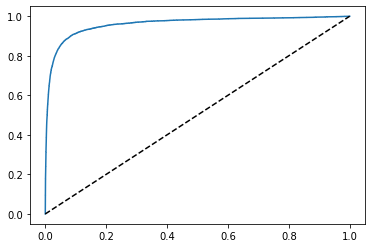

In [ ]:
##ROC CURVE.....plots True Positive Rate||(Recall)/Sensitivity VS False Positive Rate||1-specificity

from sklearn.metrics import roc_curve

fpr,tpr,thresholds=roc_curve(y_train_5,y_scores)


def plot_roc_curve(fpr,tpr,label=None):
  plt.plot(fpr,tpr,label=None)
  plt.plot([0,1],[0,1],'k--')

plot_roc_curve(fpr,tpr)
plt.show()

In [ ]:
##We can compare classifiers using roc_auc_score

from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5,y_scores)

0.9604938554008616

In [ ]:
##When to user PvsRecall and ROC
##PR---WHEN POSITIVE CLASS IS RARE OR WHEN FALSE POSIVITES ARE MORE IMPORTANT THAN FALSE NEGATIVES
##ROC----FOR OTHERWISE


In [ ]:
from sklearn.ensemble import RandomForestClassifier

forest_clf=RandomForestClassifier(random_state=42)
y_probas_forest=cross_val_predict(forest_clf,X_train,y_train_5,cv=3,method="predict_proba")


In [ ]:
y_scores_forest=y_probas_forest[:,1]

In [ ]:
fpr_forest,tpr_forest,thresholds_forest=roc_curve(y_train_5,y_scores_forest)

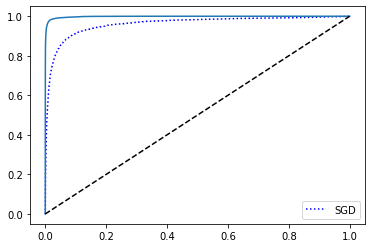

In [ ]:
plt.plot(fpr,tpr,"b:",label="SGD")
plot_roc_curve(fpr_forest,tpr_forest,"Random Forest")
plt.legend(loc="lower right")
plt.show()

In [ ]:
##Multiclass classification
##Srategies-
##one vs one(Doesnt scale well with larger datasets..SVM)
##one vs all_

sgd_clf.fit(X_train,y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [ ]:
some_digit_scores=sgd_clf.decision_function([some_digit])

In [ ]:
some_digit_scores##scores assigned by the 10 classifiers....this sample was mis classified as 3...as evident from the highest score in index 3

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [ ]:
cross_val_score(sgd_clf,X_train,y_train,cv=3,scoring='accuracy')

array([0.87365, 0.85835, 0.8689 ])

In [ ]:
##Now after scaling them inputs

from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
X_train_scaled=scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf,X_train_scaled,y_train,cv=3,scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

In [ ]:
##PLOTTING THE CONF MATRIX

y_train_pred=cross_val_predict(sgd_clf,X_train_scaled,y_train,cv=3)
conf_mx=confusion_matrix(y_train,y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

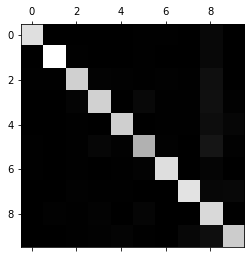

In [ ]:
plt.matshow(conf_mx,cmap=plt.cm.gray)

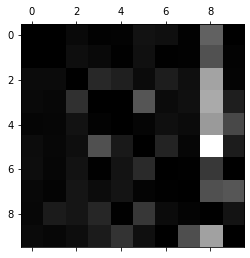

In [ ]:
 ##LET's check what kind of error this classifier makes
 row_sums=conf_mx.sum(axis=1,keepdims=True)
 norm_conf_mx=conf_mx/row_sums##so that abundant classes don't appear shitty

 ##Filling the correct ones with zero..cuz we don't wanna find out why they are right

 np.fill_diagonal(norm_conf_mx,0)
 plt.matshow(norm_conf_mx,cmap=plt.cm.gray)



In [ ]:
##5 and 3 are misclassified a lot as the other one
##A lot of numbers are misclassified as 8

In [ ]:
##MULTILABEL CLASSIFICATION
from sklearn.neighbors import KNeighborsClassifier

y_train_large=(y_train>=7)
y_train_odd=(y_train%2==1)
y_multilabel=np.c_[y_train_large,y_train_odd]

knn_clf=KNeighborsClassifier()
knn_clf.fit(X_train,y_multilabel)

knn_clf.fit(X_train,y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [ ]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [ ]:
+    